In [1]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, \
                            median_absolute_error, mean_absolute_percentage_error
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")


def calcError(y_test, y_pred):
#     R2 = r2_score(y_test, y_pred)
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
#     print(f'R2: {round(R2,4)}')
    print(f'Mean Squared Error: {round(MSE,4)}')
    print(f'Root Mean Sqarred Error: {round(RMSE,4)}')
    print(f'Mean Absolute Error: {round(MAE,4)}')
    print(f'Mean Absolute Percentage Error: {round(MAPE*100,4)}')
    return

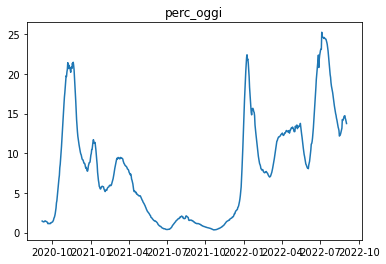

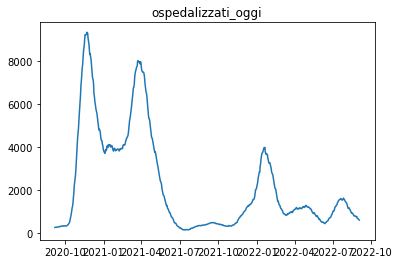

,perc_oggi,ospedalizzati_oggi
date,,
2022-08-24,14.137143,775.0
2022-08-25,14.265714,780.0
2022-08-26,14.380000,780.0
2022-08-27,14.650000,780.0
2022-08-28,14.705714,694.0
2022-08-29,14.742857,688.0
2022-08-30,14.430000,680.0
2022-08-31,14.257143,655.0
2022-09-01,14.020000,627.0


In [2]:
# creazione dataframe
data = pd.read_csv('https://www.lombacovid.it/story.csv',usecols = ['data','perc_story','ospedalizzati_story'])
data['data'] = pd.to_datetime(data['data'], dayfirst=True)
data.rename(columns = {'ospedalizzati_story':'ospedalizzati_oggi',
                       'perc_story':'perc_oggi',
                       'data':'date'},
                            inplace = True)
data.set_index('date',inplace=True)

# feature engineering on perc_oggi smoothed by running average of 7 days
running_average = 7     
data['perc_oggi'] = data['perc_oggi'].rolling(window=running_average).mean()
data = data.dropna()

for i in data:
    plt.plot(data[i])
    plt.title(i)
    plt.show()

# time series of ospedalizzati
series = data.ospedalizzati_oggi


display(data.tail(10))

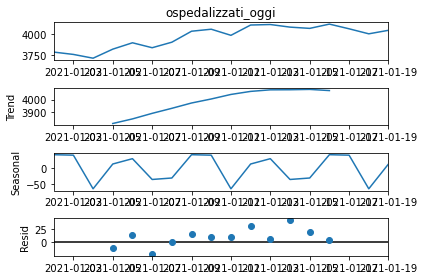

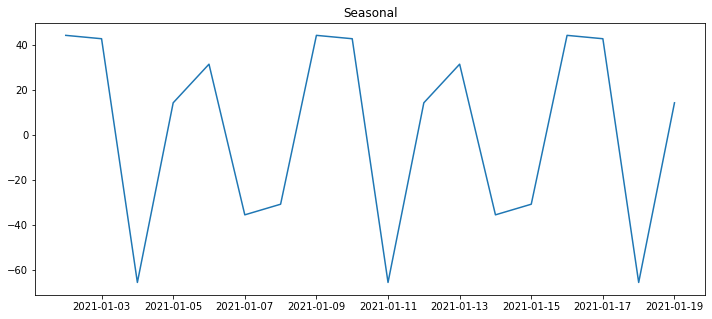

In [3]:
# visualize seasonal and trend component of ospedalizzati

sub_series = series[(series.index > '2021-01-01') & (series.index < '2021-01-20')]
result = seasonal_decompose(sub_series, model='additive')
result.plot()
plt.show()


plt.figure(figsize=(12,5))
plt.plot(result.seasonal)
plt.title('Seasonal')
plt.show()


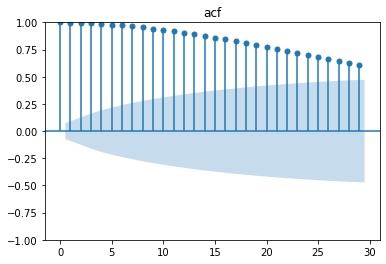

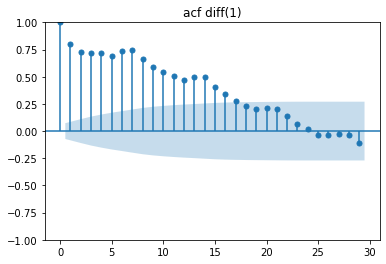

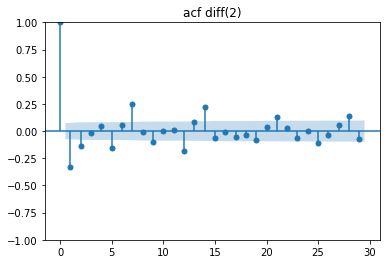

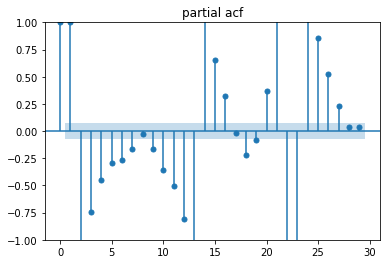

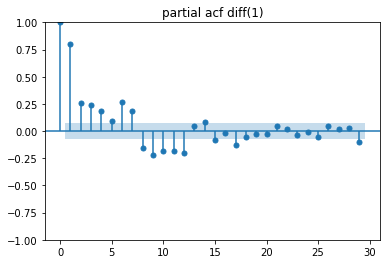

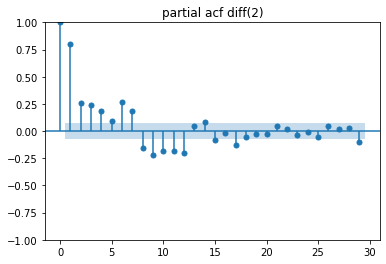

In [4]:
# visualize acf and partial acf of ospedalizzati 

plot_acf(series)
plt.title('acf')
plt.show()

plot_acf(series.diff().dropna())
plt.title('acf diff(1)')
plt.show()

plot_acf(series.diff().diff().dropna())
plt.title('acf diff(2)')
plt.show()

plot_pacf(series)
plt.title('partial acf')
plt.show()

plot_pacf(series.diff().dropna())
plt.title('partial acf diff(1)')
plt.show()

plot_pacf(series.diff().dropna())
plt.title('partial acf diff(2)')
plt.show()

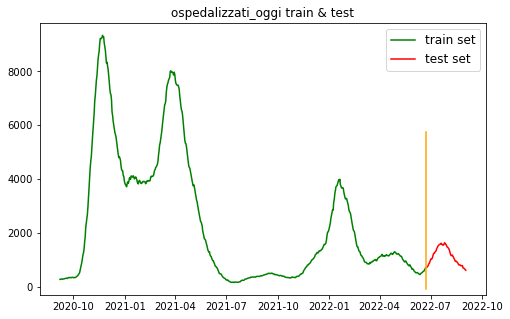

In [5]:
# splitting test and train
len_train_train_test = int(len(series.index)-len(series.index)*10/100)
index_train_test = list(data.index)[len_train_train_test]

y_train = series[series.index <= index_train_test]
y_test = series[series.index > index_train_test]

# plot train
plt.figure(figsize=(8,5))
plt.plot(y_train,color='green',label='train set')
plt.plot(y_test,color='red',label='test set')
plt.axvline(x=index_train_test, ymin = 0.02, ymax = 0.6, color='orange')
plt.title('ospedalizzati_oggi train & test')
plt.legend(prop={'size': 12})
plt.show()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=7507.674, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=12052.416, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=12495.080, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7213.236, Time=1.34 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7215.470, Time=1.83 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7215.051, Time=1.23 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=7334.241, Time=1.05 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=7215.231, Time=2.08 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=6965.952, Time=1.21 sec
 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=7067.977, Time=0.36 sec
 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=6945.907, Time=1.91 sec
 ARIMA(2,0,1)(2,0,1)[7] intercept   : AIC=6934

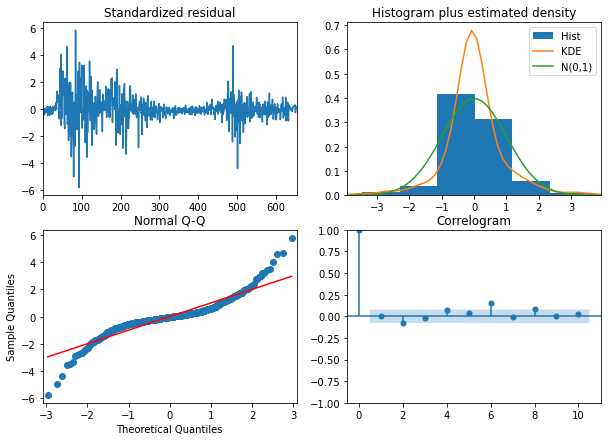

In [6]:
# -> SARIMA - train/test
model = pm.auto_arima(y = y_train,
                          start_p=1, start_q=1, d=None,
                          max_p=5, max_q=5,
                          start_P=0, start_Q=0, D=None,
                          seasonal=True,
                          m = 7,
                          test='adf',
                          n_jobs=-1,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)


# diagnostic of the model
model.plot_diagnostics(figsize=(10,7))
plt.show()

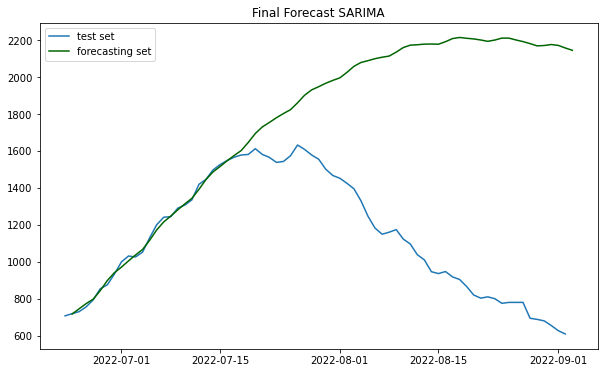

Error on test SARIMA
Mean Squared Error: 719160.1585
Root Mean Sqarred Error: 848.0331
Mean Absolute Error: 617.7729
Mean Absolute Percentage Error: 69.0032


In [7]:
# Forecast of test set SARIMA
n_periods = len(y_test)
fc, confint = model.predict(n_periods = n_periods, return_conf_int=True)
index_of_fc = pd.date_range(y_test.index[1], periods = n_periods, freq='D')

# make series for plotting purpose
fc_series_test = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test,label='test set')
plt.plot(fc_series_test, color='darkgreen',label='forecasting set')
plt.legend()
plt.title("Final Forecast SARIMA")
plt.show()

# error
print('Error on test SARIMA')
calcError(y_test,fc_series_test)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=8271.783, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=13323.473, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.84 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=13804.190, Time=0.01 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=7948.719, Time=1.37 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=7952.168, Time=1.96 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=7950.550, Time=1.73 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=8083.736, Time=1.27 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=7948.642, Time=1.93 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=7912.095, Time=2.61 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=7929.475, Time=2.21 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=inf, Time=3.45 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.95 sec
 ARIMA(2,0,1)(2,0,2)[7] intercept   : AIC=7640.440,

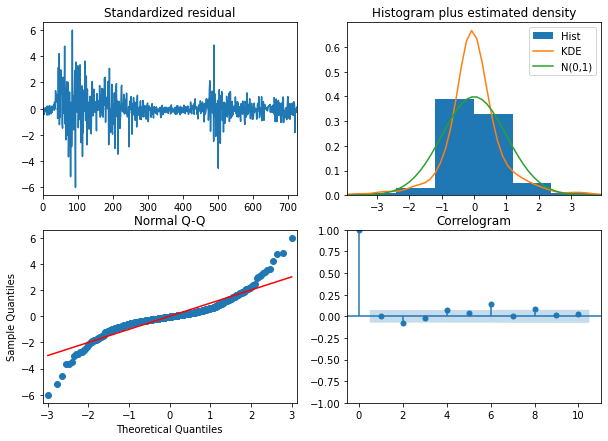

In [8]:
# -> SARIMA on all series
arima_model_all = pm.auto_arima(y = series,
                          start_p=1, start_q=1, d=None,
                          max_p=5, max_q=5,
                          start_P=0, start_Q=0, D=None,
                          seasonal=True,
                          m = 7,
                          test='adf',
                          n_jobs=-1,
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

# diagnostic of the model
arima_model_all.plot_diagnostics(figsize=(10,7))
plt.show()



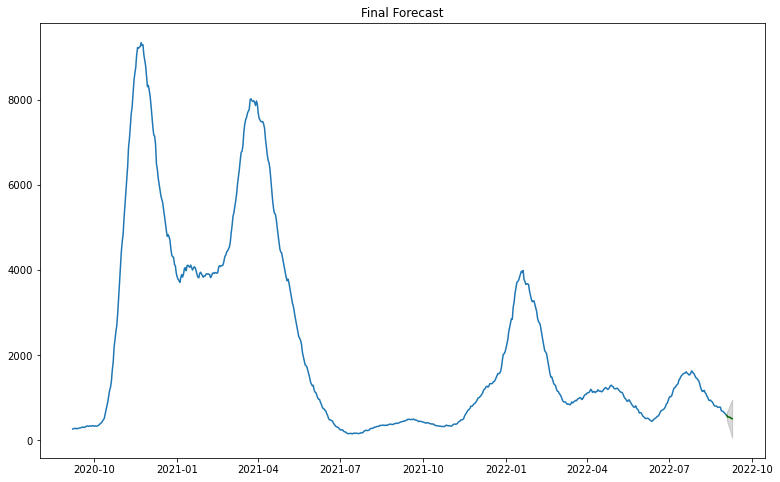

In [9]:
# Forecast SARIMA on all
n_periods = 7
fc, confint = arima_model_all.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(series.index[-1]+timedelta(days=1), periods = n_periods, freq='D')

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(13,8))
plt.plot(series)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.show()

In [10]:
fc_series.head(n_periods)

2022-09-03    588.894011
2022-09-04    549.206814
2022-09-05    546.442726
2022-09-06    548.010702
2022-09-07    534.309148
2022-09-08    520.779589
2022-09-09    508.286188
Freq: D, dtype: float64